<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/reinforcement_learning/examples/reinforcement_learning/tabular/actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this final algorithm, the only additional object we need to define is the algorithm itself. First we again reuse code by importing from the source folder.

In [92]:
import sys
import os
source_path = os.path.join("source/")
sys.path.insert(0,source_path)
import environments # pylint: disable = import-error
import algorithms # pylint: disable = import-error
import tables # pylint: disable = import-error

The new algorithm is particularly simple: we simply inherit most of the structure from the base episodic_algorithm class, modifying the _per_step function to update the policy and value of the state prior to the current transition, using the value of the state after and the reward in between.

In [93]:
class actor_critic(algorithms.episodic_algorithm):
	"""Uses the value as a baseline and an estimate of future returns."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.values = parameters['values']

	def _update(self):
		"""Updates the policy and value for the previous state."""
		past_value = self.values.forward(self.past_state)
		current_value = self.values.forward(self.current_state)
		td_error = current_value + self.reward - past_value
		self.values.step(self.past_state, td_error)
		self.policy.step(self.past_state, td_error, self.eligibility)

	def _per_step(self):
		"""Overrides the _per_step method, to transition and update each step."""
		self._transition()
		self._update()

For testing, we again initialize the environment, tables, and now three agents using the three algorithms discussed.

In [94]:
environment_parameters = dict(
	trajectory_length = 20, 
	positivity_bias = 1,
	target_bias = 2,
)
environment = environments.excursions(environment_parameters)

table_dimension = (environment_parameters['trajectory_length']*2 + 1, 
				   environment_parameters['trajectory_length'] + 1)
policy1 = tables.two_action_policy_table(table_dimension, 0.15)
values2 = tables.value_table(table_dimension, 0.6)
policy2 = tables.two_action_policy_table(table_dimension, 0.15)
values3 = tables.value_table(table_dimension, 0.6)
policy3 = tables.two_action_policy_table(table_dimension, 0.15)

algorithm_parameters1 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	policy = policy1,
)
algorithm_parameters2 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	values = values2,
	policy = policy2,
)
algorithm_parameters3 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	values = values3,
	policy = policy3,
)
agent1 = algorithms.monte_carlo_returns(algorithm_parameters1)
agent2 = algorithms.monte_carlo_value_baseline(algorithm_parameters2)
agent3 = actor_critic(algorithm_parameters3)

We then follow the same procedure as the previous notebooks, starting with evaluation of the initial policy.

Initial return: -31.444000000000006


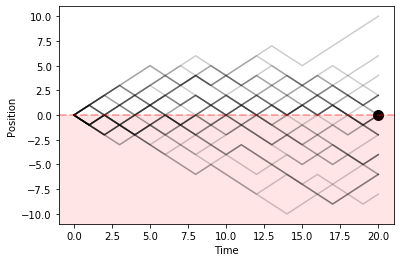

In [95]:
from matplotlib import pyplot as plt
import numpy as np

initial_return = agent1.evaluate(1000)
agent2.average_return = initial_return
agent3.average_return = initial_return
print("Initial return: %s"%(initial_return))
initial_samples = agent1.samples(30)

min_y = np.min(np.array(initial_samples)[:,:,0]) - 1
max_y = np.max(np.array(initial_samples)[:,:,0]) + 1

plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 100)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

Next we train all three agents, plotting their returns.

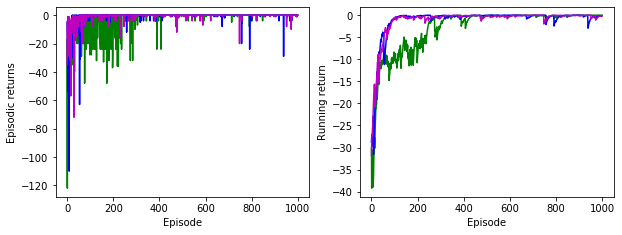

In [96]:
episodes = 1000
agent1.train(episodes)
agent2.train(episodes)
agent3.train(episodes)

plt.figure(figsize = (10, 3.5))
plt.subplot(121)
plt.plot(agent3.returns, c = 'g')
plt.plot(agent1.returns, c = 'b')
plt.plot(agent2.returns, c = 'm')
plt.xlabel("Episode")
plt.ylabel("Episodic returns")
plt.subplot(122)
plt.plot(agent3.average_returns, c = 'g')
plt.plot(agent1.average_returns, c = 'b')
plt.plot(agent2.average_returns, c = 'm')
plt.xlabel("Episode")
plt.ylabel("Running return")
plt.show()

Finally, we once again compare these resulting policies with the initial one.

Initial return: -31.444000000000006, agent1's final return: -0.09100000000000005, agent2's final return: -0.03899999999999999, agent3's final return: -0.0889999999999999


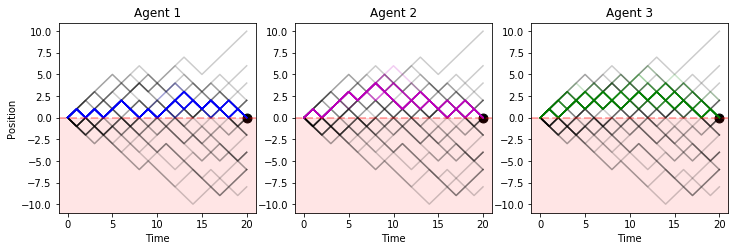

In [97]:
final_return1 = agent1.evaluate(1000)
final_return2 = agent2.evaluate(1000)
final_return3 = agent3.evaluate(1000)
print("Initial return: %s, agent1's final return: %s, agent2's final return: %s, agent3's final return: %s"
%(initial_return, final_return1, final_return2, final_return3))
samples1 = agent1.samples(30)
samples2 = agent2.samples(30)
samples3 = agent3.samples(30)

plt.figure(figsize = (12, 3.5))
plt.subplot(131)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples1)[:,:,0].T, c = 'b', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 1")
plt.xlabel("Time")
plt.ylabel("Position")
plt.subplot(132)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples2)[:,:,0].T, c = 'm', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 2")
plt.xlabel("Time")
plt.subplot(133)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples3)[:,:,0].T, c = 'g', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 3")
plt.xlabel("Time")

plt.show()